In [ ]:
import os
import pandas as pd
import numpy as np
from torchtyping import TensorType

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch.utils.data import DataLoader, TensorDataset

from tqdm import trange
from rdkit import Chem
from rdkit import DataStructs

import matplotlib.pyplot as plt
device = torch.device('cuda')
work_dir = r'E:/Coding/jupyter_root/Kaggle/neurips-open-polymer-prediction-2025/polymer_prediction_notebook'

In [2]:
train_csv = pd.read_csv(os.path.join(work_dir, './train.csv'))
test_csv = pd.read_csv(os.path.join(work_dir, './test.csv'))
merge_csv = pd.concat([train_csv, test_csv], axis = 0)
merge_csv = merge_csv.drop(columns = 'id')
#merge_csv = merge_csv.fillna(merge_csv['FFV'], axis=0).mean()
merge_csv = merge_csv.fillna({'FFV': merge_csv['FFV'].mean()})
merge_csv.to_csv(os.path.join(work_dir, './merge.csv'))

In [3]:
merge_csv

,SMILES,Tg,FFV,Tc,Density,Rg
0,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN
...,...,...,...,...,...,...
7971,*C=C(*)c1ccccc1C,261.662355,0.367212,NaN,NaN,NaN
7972,*c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCC...,NaN,0.374049,NaN,NaN,NaN
0,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...,NaN,0.367212,NaN,NaN,NaN
1,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...,NaN,0.367212,NaN,NaN,NaN


In [4]:
def transform_matrix(df:pd.DataFrame):

    '''
    Add a new column *input* containing feature matrix 
    in the shape of (num_atoms, features)
    for each molecule.

    '''
    def _get_feature_vec(atom):
        return np.array([
            atom.GetAtomicNum(), 
            atom.GetTotalDegree(), 
            atom.GetFormalCharge(), 
            int(atom.GetIsAromatic()), 
            atom.GetTotalNumHs()
        ], dtype=float)
    def _molecule_features(molecule):
        try:
            feature_mtx = torch.tensor(
                [_get_feature_vec(atom) for atom in molecule.GetAtoms()], 
                dtype = torch.float
            )
            return feature_mtx
        except Exception as e:
            print(f'Error occurs: {e}')
            return None
       
    
    molecules = df['SMILES'].apply(lambda smile : Chem.MolFromSmiles(smile))
    df['input'] = molecules.apply(_molecule_features)
    return df


def similarity(
        df,
        n_componds:int
):
    all_smiles = df['SMILES'][:n_componds]
    mols = [Chem.MolFromSmiles(smile) for smile in all_smiles]
    fps = [Chem.RDKFingerprint(mol) for mol in mols]
    similarity_matrix = torch.empty((len(fps), len(fps)), dtype=torch.float32)
    for i in trange(len(similarity_matrix)):
        for j in range(i+1, len(similarity_matrix)):
            similarity_matrix[i][j] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

    return similarity_matrix


def get_symetric_similarity_matrix(
        matrix_tensor:str, 
        threshold:float, 
        set_one:bool, 
        save
):
    similarity_matrix = torch.load(os.path.join(work_dir, matrix_tensor))
    mask = (similarity_matrix>= threshold)
    
    if set_one:
        mask:bool = mask | mask.T
        matrix:TensorType = 1*mask
    else:
        matrix = similarity_matrix * mask
        matrix = matrix + matrix.T 
    matrix = matrix.fill_diagonal_(True)
    if save:
        torch.save(matrix, f'{os.path.join(work_dir, save)}.pt')
    return matrix


In [5]:
merge_csv = transform_matrix(merge_csv)
merge_csv

C:\Users\hp\AppData\Local\Temp\ipykernel_20640\3783369607.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  feature_mtx = torch.tensor(


,SMILES,Tg,FFV,Tc,Density,Rg,input
0,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
...,...,...,...,...,...,...,...
7971,*C=C(*)c1ccccc1C,261.662355,0.367212,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
7972,*c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCC...,NaN,0.374049,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
0,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...,NaN,0.367212,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."
1,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...,NaN,0.367212,NaN,NaN,NaN,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0..."


In [6]:
all_smiles = merge_csv['SMILES']
similarity_matrix = torch.load(os.path.join(work_dir, './similarity_matrix.pt'))
weighted_similarity_matrix = get_symetric_similarity_matrix(    
    './similarity_matrix.pt', 
    0.7, False, 'similarity_matrix_weighted'
)
# Use torch.load() when the weighted_similarity_matrix is saved. 
# This matrix is expected to be features input
edge_index = weighted_similarity_matrix.to_sparse_coo()
edge_index

C:\Users\hp\AppData\Local\Temp\ipykernel_20640\3644710433.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  similarity_matrix = torch.load(os.path.join(work_dir, './simila

tensor(indices=tensor([[   0,    0,    0,  ..., 7975, 7975, 7975],
                       [   0,  341,  756,  ..., 7629, 7861, 7975]]),
       values=tensor([1.0000, 0.9112, 0.9704,  ..., 0.7114, 0.7659, 1.0000]),
       size=(7976, 7976), nnz=237146, layout=torch.sparse_coo)

In [28]:
all_labels = merge_csv.drop(columns=['input', 'SMILES'])

df_without_na = all_labels.dropna(axis=0, how='any')
labeled_index = df_without_na.index
train_mask = np.zeros(len(all_labels), dtype = np.bool)
train_mask[labeled_index] = True
all_labels = torch.tensor(all_labels.values, dtype=torch.float32).to(device)

In [8]:
feature_matrix = torch.load(os.path.join(work_dir, 'input_tensors.pt'))
feature_matrix

C:\Users\hp\AppData\Local\Temp\ipykernel_20640\221370011.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature_matrix = torch.load(os.path.join(work_dir, 'input_tensor

[tensor([[0., 1., 0., 0., 0.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 1.],
         [0., 1., 0., 0., 0.],
         [6., 3., 0., 1., 0.],
         [6., 3., 0., 1., 1.],
         [6., 3., 0., 1., 1.],
         [6., 3., 0., 1., 1.],
         [6., 3., 0., 1., 1.],
         [6., 3., 0., 1., 0.],
         [6., 3., 0., 0., 0.],
         [8., 1., 0., 0., 0.],
         [8., 2., 0., 0., 0.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 3.]]),
 tensor([[0., 1., 0., 0., 0.],
         [7., 3., 0., 0., 1.],
         [6., 3., 0., 1., 0.],
         [6., 3., 0., 1., 1.],
         [6., 3., 0., 1., 1.],
         [6., 3., 0., 1., 0.],
         [6., 4., 0., 0., 1.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 2.],
         [6., 4., 0., 0., 3.],
         [6., 3., 0., 1., 0.],
         [6., 3., 0., 1., 1.],
         [6., 3., 0., 1., 1.],
      

In [9]:
class AtomGAT(nn.Module):
    def __init__(
            self, 
            in_channels, 
            num_hidden, 
            out_channels, 
            heads, 
            dropout
    ):
        super().__init__()
        self.gatlayer1 = GATConv(
            in_channels=in_channels, 
            out_channels=num_hidden, 
            heads = heads, dropout=dropout, 
        )
        self.gatlayer2 = GATConv(
            in_channels= num_hidden * heads, 
            out_channels=out_channels, 
            heads = 1, 
            concat=False
        )
    def forward(
            self, 
            x, 
            edge_index
    ):
        x = F.elu(self.gatlayer1(x, edge_index))
        x = self.gatlayer2(x, edge_index)
        return x
    
#model = AtomGAT(
    #feature_matrix[0].shape[1], 
    #64, 5, 4, 0.1
#)

class MolGAT(nn.Module):
    def __init__(
            self, 
            atom_infeature, 
            atom_hidden, 
            atom_outfeature,
            atom_gat_heads, 
            atom_dropout, 
            n_hidden, 
            n_heads, 
            n_class,
            dropout
    ):
        super().__init__()
        self.atomgat = AtomGAT(
            atom_infeature, atom_hidden, atom_outfeature, atom_gat_heads, atom_dropout
        )
        self.gatlayer1 = GATConv(atom_outfeature, n_hidden, n_heads, dropout=dropout)
        self.gatlayer2 = GATConv(n_hidden * n_heads, n_class, concat = False)

    def forward(
            self, 
            atom_feature_matrix, atom_edge_idx, 
            mol_edge_index,
            batch, 
    ):
        x = self.atomgat(atom_feature_matrix, atom_edge_idx)
        x = global_mean_pool(x, batch)
        x = F.elu(self.gatlayer1(x, mol_edge_index))
        x = self.gatlayer2(x, mol_edge_index)
        return x


In [ ]:
input_tensor = torch.load(os.path.join(work_dir, './input_tensor_cat.pt'))
atom_edge_index = torch.load(os.path.join(work_dir, 'edge_index.pt'))
batch = torch.load(os.path.join(work_dir, 'batch.pt'))
input_tensor.shape, atom_edge_index.shape, batch.shape

C:\Users\hp\AppData\Local\Temp\ipykernel_20640\3633158820.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_tensor = torch.load(os.path.join(work_dir, './input_tenso

(torch.Size([273561, 5]), torch.Size([2, 589544]), torch.Size([273561]))

In [12]:
model = AtomGAT(
    in_channels=feature_matrix[0].shape[1], 
    num_hidden=64, out_channels=5, heads=4, dropout=0.1
)
atom_output = model(input_tensor, atom_edge_index)
atom_output.shape

torch.Size([273561, 5])

In [13]:
global_model = MolGAT(5, 16, 5, 4, 0.1, 16, 4, 5, 0.1)
global_model(input_tensor, atom_edge_index, edge_index, batch)

tensor([[ 0.1514,  0.0254, -0.1282,  0.0426, -0.2695],
        [ 0.1551,  0.0203, -0.1461,  0.0565, -0.2900],
        [ 0.1546,  0.0531, -0.0745, -0.0656, -0.1254],
        ...,
        [ 0.1418,  0.0339, -0.1366, -0.0208, -0.1477],
        [ 0.1453,  0.0606, -0.1167, -0.0177, -0.1813],
        [ 0.1372,  0.0511, -0.1269, -0.0469, -0.1382]], grad_fn=<AddBackward0>)

100%|██████████| 512/512 [00:25<00:00, 20.17it/s]


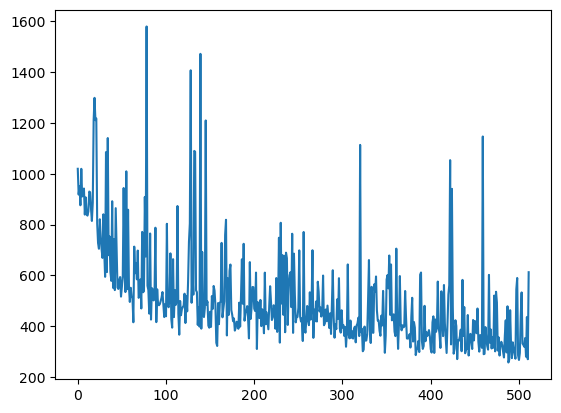

In [37]:
def trainer(
        input_tensor, 
        atom_edge_index, 
        edge_index, 
        batch,
        lr,
        num_epoch, 

):
    global_model.to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(global_model.parameters(), lr = lr)
    loss_list = []
    for epoch in trange(num_epoch):
        global_model.train()
        optimizer.zero_grad()
        pred = global_model(input_tensor.to(device), atom_edge_index.to(device), edge_index.to(device), batch.to(device))

        ls = loss_fn(pred[train_mask], all_labels[train_mask])
        ls.backward()
        optimizer.step()
        
        #global_model.eval()
        #with torch.no_grad():
            #test_ls = loss_fn(pred(val_mask.numpy()), all_labels[val_mask.numpy()])
        loss_list.append(ls)
    return loss_list
ls = trainer(input_tensor, atom_edge_index, edge_index, batch, lr = 0.001, num_epoch = 512)
plt.plot(np.arange(len(ls)), [v.cpu().detach().numpy() for v in ls])

In [30]:
ls

[tensor(3887.7898, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3887., device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3882.9280, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3879.6848, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3877.2168, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3873.3450, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3871.3071, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3866.9661, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3862.6082, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3857.5764, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3852.4758, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3849.6797, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3852.1184, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3839.7097, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3835.7998, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(3828.9856, device='cu

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

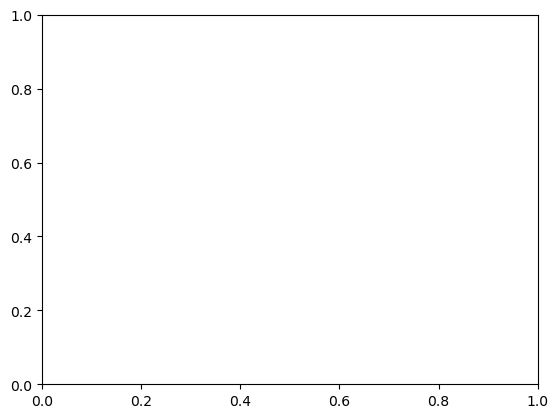

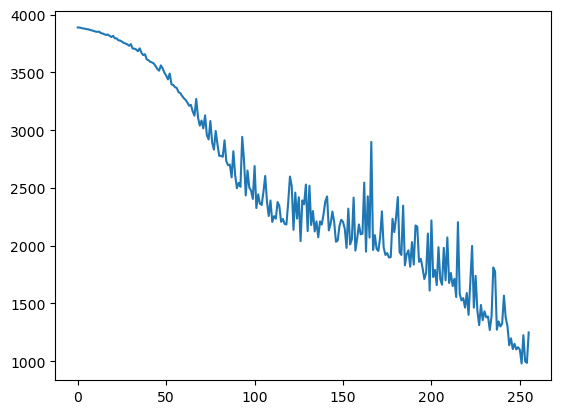